# Predicting Attrition

<a class="anchor" id="1st-bullet"></a>

# 0. Workspace Setup

In [1]:
#!pip install pandas
#!pip install numpy
#!pip install -U matplotlib
#!pip install -U seaborn
#!pip install -U scikit-learn
#!pip install imbalanced-learn
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import linear_model

In [2]:
cwd = os.getcwd()
for i in os.listdir(cwd):
    if "csv" in i:
        df = pd.read_csv(i)

In [3]:
df

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,...,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,...,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,...,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,...,4,80,0,17,3,2,9,6,0,8


# 1. Data Preprocessing

## 1.1. Train-Test Split
Since the data was already cleaned, we can start splitting the data to feed the model we will build.

In [4]:
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})
X = df.drop('Attrition', axis = 1)
y = df['Attrition'].copy()

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Dimensions of X_train:", X_train.shape)
print("Dimensions of X_test:", X_test.shape)
print("Dimensions of y_train:", y_train.shape)
print("Dimensions of y_test:", y_test.shape)

Dimensions of X_train: (1176, 34)
Dimensions of X_test: (294, 34)
Dimensions of y_train: (1176,)
Dimensions of y_test: (294,)


## 1.2. Feature Transformation
- Removal of irrelevant features
- Transformation of categorical variables
- Feature scaling and SMOTE

### 1.2.1. Removal of irrelevant features

The features below were deemed either constant or irrelevant for the analysis.

In [6]:
irrelevant_features = ['EmployeeCount', 'EmployeeNumber', 'StandardHours']

X_train = X_train.drop(irrelevant_features, axis=1)

### 1.2.2. Transformation of categorical features

Notes:
- Some variables are wrongly classified as numerical.
- Dataset was divided into categorical and numerical to prepare for feature selection.
- Categorical variables were encoded to numerical
- Over18 was removed beacuse it was constant

In [7]:
#Identify wrongly classified numerical variables

cat_num = [
    'Education',
    'EnvironmentSatisfaction',
    'JobInvolvement',
    'JobLevel',
    'JobSatisfaction',
    'WorkLifeBalance',
    'StockOptionLevel',
    'RelationshipSatisfaction',
    'PerformanceRating'
]

In [8]:
# Splitting dataset between categorical and numerical variables

categoricalVar = df.select_dtypes(include=['object']).columns.tolist()
numericalVar= df.select_dtypes(exclude=['object']).columns.tolist()
categorical = pd.concat([df[categoricalVar], df[cat_num]], axis=1)
numerical = df[numericalVar]

In [9]:
categorical

,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,OverTime,Education,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,WorkLifeBalance,StockOptionLevel,RelationshipSatisfaction,PerformanceRating
0,Travel_Rarely,Sales,Life Sciences,Female,Sales Executive,Single,Y,Yes,2,2,3,2,4,1,0,1,3
1,Travel_Frequently,Research & Development,Life Sciences,Male,Research Scientist,Married,Y,No,1,3,2,2,2,3,1,4,4
2,Travel_Rarely,Research & Development,Other,Male,Laboratory Technician,Single,Y,Yes,2,4,2,1,3,3,0,2,3
3,Travel_Frequently,Research & Development,Life Sciences,Female,Research Scientist,Married,Y,Yes,4,4,3,1,3,3,0,3,3
4,Travel_Rarely,Research & Development,Medical,Male,Laboratory Technician,Married,Y,No,1,1,3,1,2,3,1,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,Travel_Frequently,Research & Development,Medical,Male,Laboratory Technician,Married,Y,No,2,3,4,2,4,3,1,3,3
1466,Travel_Rarely,Research & Development,Medical,Male,Healthcare Representative,Married,Y,No,1,4,2,3,1,3,1,1,3
1467,Travel_Rarely,Research & Development,Life Sciences,Male,Manufacturing Director,Married,Y,Yes,3,2,4,2,2,3,1,2,4
1468,Travel_Frequently,Sales,Medical,Male,Sales Executive,Married,Y,No,3,4,2,2,2,2,0,4,3


In [10]:
X_train.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1097,24,Travel_Rarely,350,Research & Development,21,2,Technical Degree,3,Male,57,...,3,2,3,2,3,3,1,1,0,0
727,18,Non-Travel,287,Research & Development,5,2,Life Sciences,2,Male,73,...,3,4,0,0,2,3,0,0,0,0
254,29,Travel_Rarely,1247,Sales,20,2,Marketing,4,Male,45,...,3,4,1,10,2,3,3,2,0,2
1175,39,Travel_Rarely,492,Research & Development,12,3,Medical,4,Male,66,...,4,3,0,7,3,3,5,4,1,0
1341,31,Travel_Rarely,311,Research & Development,20,3,Life Sciences,2,Male,89,...,3,1,1,10,2,3,10,8,0,2


In [11]:
# Variable Encoding by normalization with dictionary to store original data

from sklearn.preprocessing import LabelEncoder

def process_categorical_data(data, text_categorical_features, le, l1, l2, tf1):
    for i in data.columns:
        if type(data[i][0]) == str:
            text_categorical_features.append(i)
            data[i] = le.fit_transform(data[i])
            l1.append([int(val) for val in data[i].unique()])
            l2.append(list(le.inverse_transform(data[i].unique())))
    for i in range(len(text_categorical_features)):
        tf1[text_categorical_features[i]] = {}
        for j, k in zip(l1[i], l2[i]):
            tf1[text_categorical_features[i]][j] = k
                   
# Encoding on X_train
le = LabelEncoder()
text_categorical_features = []
l1 = []
l2 = []
tf1 = {}
process_categorical_data(X_train, text_categorical_features, le, l1, l2, tf1)


#  Encoding on categorical
le = LabelEncoder()
text_categorical_features = []
l1 = []
l2 = []
tf1 = {}
process_categorical_data(categorical, text_categorical_features, le, l1, l2, tf1)


In [12]:
# Describing keys and values

for key, value in tf1.items():
    # Sort the inner dictionary by its keys
    sorted_value = dict(sorted(value.items()))
    print(f"The values for {key} are: {sorted_value}")

The values for BusinessTravel are: {0: 'Non-Travel', 1: 'Travel_Frequently', 2: 'Travel_Rarely'}
The values for Department are: {0: 'Human Resources', 1: 'Research & Development', 2: 'Sales'}
The values for EducationField are: {0: 'Human Resources', 1: 'Life Sciences', 2: 'Marketing', 3: 'Medical', 4: 'Other', 5: 'Technical Degree'}
The values for Gender are: {0: 'Female', 1: 'Male'}
The values for JobRole are: {0: 'Healthcare Representative', 1: 'Human Resources', 2: 'Laboratory Technician', 3: 'Manager', 4: 'Manufacturing Director', 5: 'Research Director', 6: 'Research Scientist', 7: 'Sales Executive', 8: 'Sales Representative'}
The values for MaritalStatus are: {0: 'Divorced', 1: 'Married', 2: 'Single'}
The values for Over18 are: {0: 'Y'}
The values for OverTime are: {0: 'No', 1: 'Yes'}


In [13]:
# Drop constant variables

X_train = X_train.drop(['Over18'],axis=1)
categorical = categorical.drop(['Over18'],axis=1)

In [14]:
# X_train

### 1.2.3. Imbalance correction and standardization/normalization

- Use of oversampling (SMOTE) and undersampling (RandomUnderSampler) to correct class imbalance
- Data leakage was taken into account by the split made earlier (test set) and the use of pipeline for cross-validation
- Features were scaled as a best practice, to avoid affecting the performance of models in feature selection and model training

In [15]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Create a pipeline to correct imbalance and apply to training set

resampling_pipeline = Pipeline([
    ('oversample', SMOTE(sampling_strategy=0.85)), 
    ('undersample', RandomUnderSampler(sampling_strategy=1.0))
])

X_resampled, y_resampled = resampling_pipeline.fit_resample(X_train, y_train)


In [16]:
# Check and compare the new balance 

class_balance = pd.Series(y_train).value_counts()
class_balance_resampled = pd.Series(y_resampled).value_counts()
print("Original Class Balance:")
print(class_balance)

print("Resampled Class Balance:")
print(class_balance_resampled)

Original Class Balance:
Attrition
0    978
1    198
Name: count, dtype: int64
Resampled Class Balance:
Attrition
0    831
1    831
Name: count, dtype: int64


In [17]:
# Separate categorical features for resampled dataset

categorical_features = categorical.columns.to_list()

X_resampled_categorical = X_resampled[categorical_features]
X_resampled_numerical = X_resampled.drop(columns=categorical_features)

In [18]:
# Scalling variables and Normalization
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler()
std_scaler = StandardScaler()
X_resampled_scaled = pd.DataFrame(std_scaler.fit_transform(X_resampled_numerical), columns=X_resampled_numerical.columns)
X_resampled_normalized = pd.DataFrame(minmax_scaler.fit_transform(X_resampled_scaled), columns=X_resampled_scaled.columns)

In [19]:
X_resampled_scaled

,Age,DailyRate,DistanceFromHome,HourlyRate,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,-1.054020,-0.555392,0.045646,-1.071501,-0.244131,-0.726445,-0.689077,-0.583970,-0.654690,1.162419,-0.185138,-0.149983,-0.318243,-0.429370
1,1.126711,-0.201962,-0.997162,0.828281,0.639778,0.770943,0.134249,-0.290661,0.260444,1.162419,0.471987,1.307747,0.706795,1.076777
2,0.472492,1.085157,-0.997162,1.672628,-0.853152,-0.254514,-0.277414,-0.290661,1.306311,-0.482486,-0.185138,-0.149983,-0.659922,-0.429370
3,-0.726911,1.127358,-0.997162,0.617194,0.200775,-1.475965,-0.277414,1.175881,-0.001023,-0.482486,-1.006544,-1.024621,-0.659922,-1.031828
4,0.254419,0.597212,-0.997162,-1.863076,0.257296,0.698168,0.134249,0.002647,0.129711,0.339967,0.143425,1.016201,-0.318243,1.076777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657,-0.617874,-0.107011,-0.475758,-0.807642,-0.731711,-1.373557,0.545912,0.589264,-0.785423,-0.482486,-0.842262,-0.733075,-0.318243,-0.730599
1658,0.690565,-0.837609,1.740210,0.775509,-0.052322,-1.169017,-0.277414,-0.877278,-0.523956,1.984872,-0.513700,-0.441529,-0.659922,-1.031828
1659,0.254419,-1.135651,1.349157,1.250454,-0.441842,1.060248,-1.100741,-0.583970,-0.654690,-1.304938,-0.349419,-0.733075,-0.659922,-0.429370
1660,-0.944984,-1.074988,-0.345407,-0.754870,-0.677460,1.217650,0.134249,0.002647,-0.523956,-0.482486,-0.349419,0.141563,-0.659922,-0.730599


In [20]:
y_resampled

46      0
320     0
539     0
10      0
42      0
       ..
1804    1
1805    1
1806    1
1807    1
1808    1
Name: Attrition, Length: 1662, dtype: int64

# 2. Feature Selection

## 2.1. Categorical Variables

- Definition of feature selection function to run a chi-square model and a mutual information model on the categorical variables
- Use of cross validation to avoid misleading results
- The result from each fold was saved into a list and then an average was computed to rank the variables
- A plot was created to summarize the main results.
- The main categorical variables selected were Stock Option Level, Job Level, Job Satisfaction, Over Time, Job Involvement and Business Travel.

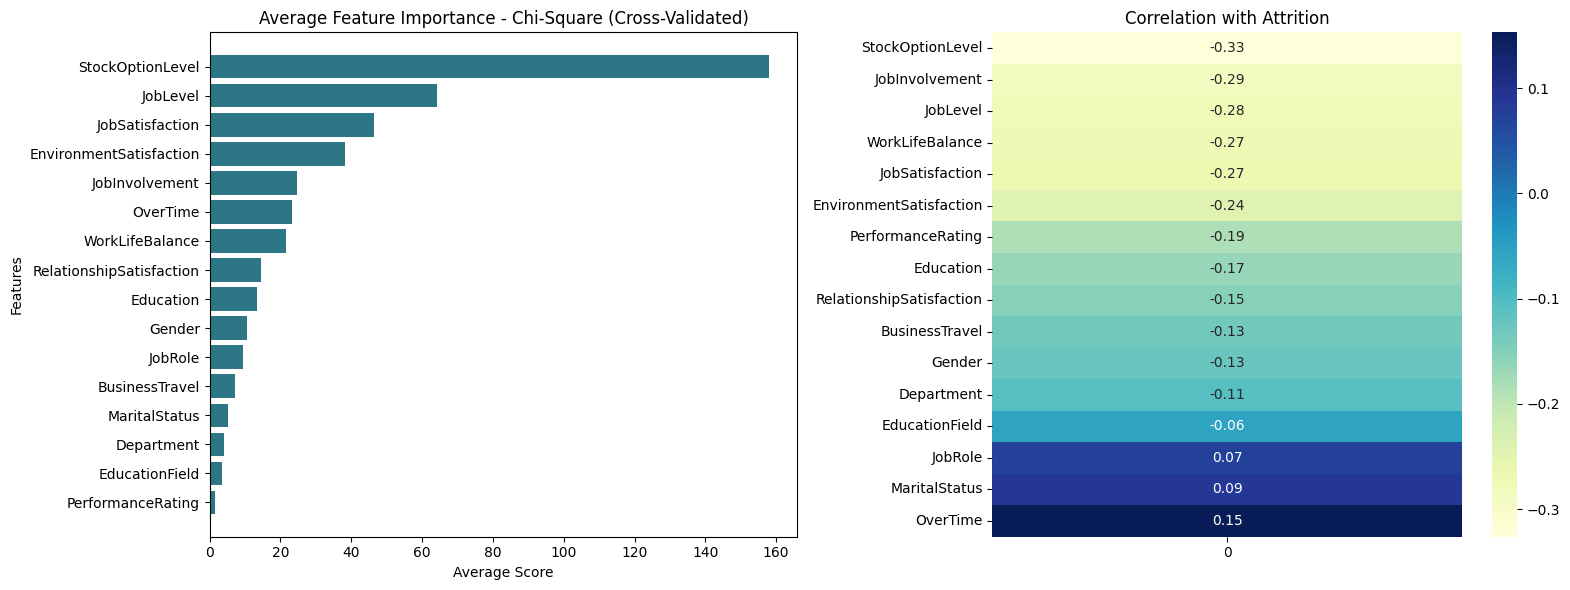

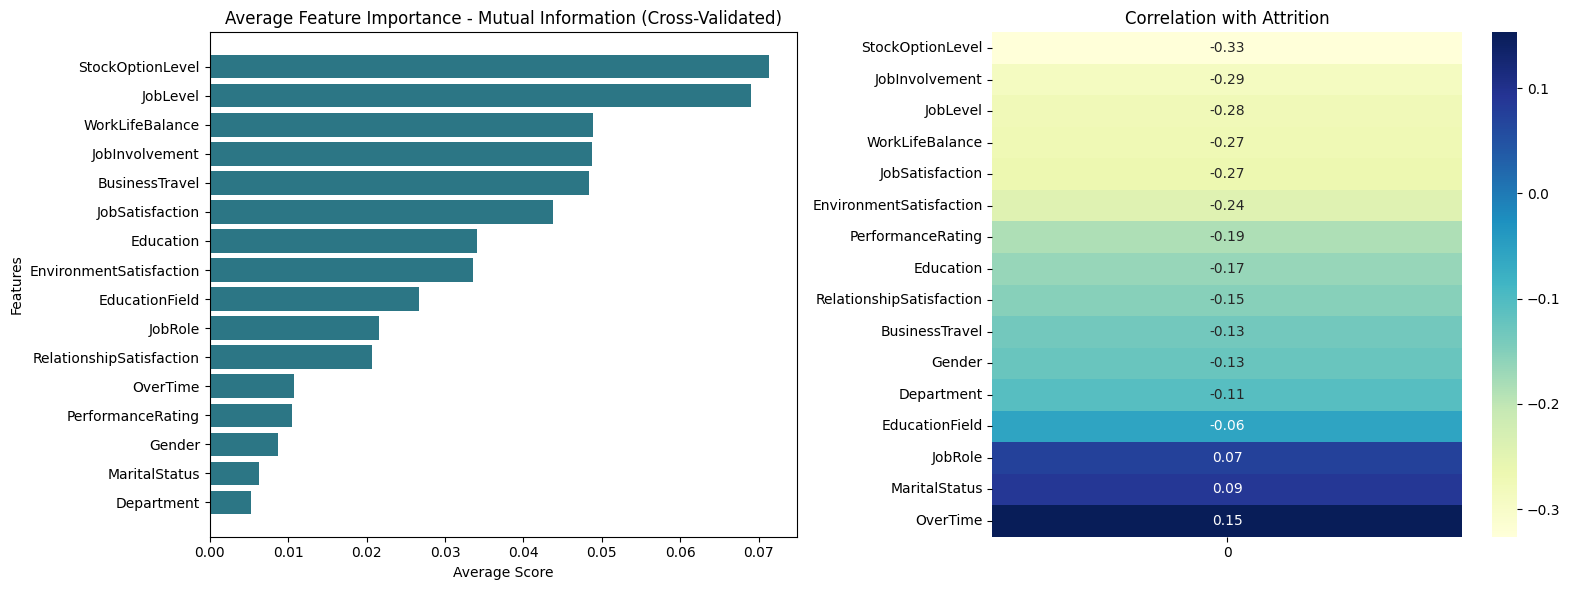

In [21]:
from sklearn.feature_selection import mutual_info_classif, chi2, SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

# Function to plot categorical variable feature selection and correlation
def plot_categorical_features(X, y, method, method_name, n_folds=5):
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

    all_feature_scores = []
    
    # Plotting variables
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Feature Selection
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        selector = SelectKBest(method, k='all')
        X_train_selected = selector.fit_transform(X_train, y_train)

        scores = selector.scores_
        feature_names = X.columns

        all_feature_scores.append(scores)

    avg_feature_scores = np.mean(all_feature_scores, axis=0)
    sorted_indices = np.argsort(avg_feature_scores)
    sorted_scores = avg_feature_scores[sorted_indices]
    sorted_feature_names = feature_names[sorted_indices]

    # Bar plot for feature selection
    axes[0].barh(range(len(sorted_scores)), sorted_scores, color='#2c7685', align='center')
    axes[0].set_yticks(range(len(sorted_scores)))
    axes[0].set_yticklabels(sorted_feature_names)
    axes[0].set_title(f"Average Feature Importance - {method_name} (Cross-Validated)")
    axes[0].set_xlabel("Average Score")
    axes[0].set_ylabel("Features")

    # Correlation Heatmap
    corr_matrix = X.corrwith(y).sort_values(ascending=True)  # Sort in ascending order
    sns.heatmap(corr_matrix.to_frame(), annot=True, cmap='YlGnBu', fmt=".2f", ax=axes[1])  # Change the colormap to 'viridis'
    axes[1].set_title("Correlation with Attrition")

    plt.tight_layout()
    # plt.savefig(method_name+'_feature_selection_and_correlation_plot.png', transparent=True, dpi=300)
    plt.show()


# Run the modified function
plot_categorical_features(X_resampled_categorical, y_resampled, chi2, "Chi-Square", n_folds=7)
plot_categorical_features(X_resampled_categorical, y_resampled, mutual_info_classif, "Mutual Information", n_folds=7)



In [22]:
categorical_variables_to_keep = [
    'StockOptionLevel',
    'JobLevel',
    'JobSatisfaction',
    'EnvironmentSatisfaction',
    'OverTime',
    'JobInvolvement',
    'BusinessTravel']

## 2.2. Numerical Variables

- Construction of a correlation matrix to exclude variables that are highly correlated with each other
- YearsAtCompany, YearsInCurrentRole, YearsSinceLastPromotion, YearsWithCurrentManager and TotalWorkingYears were highly correlated
- As a rule of thumb it was decide to keep only YearsInCurrentRole and YearsSinceLastPromotion as it will more connected to attrition
- A random forest model was run on numerical variables to determine feature importance
- Cross validation was used to ensure consitency in results
- It was decided to keep variables with more than 0.075 importance resulting in the following variables


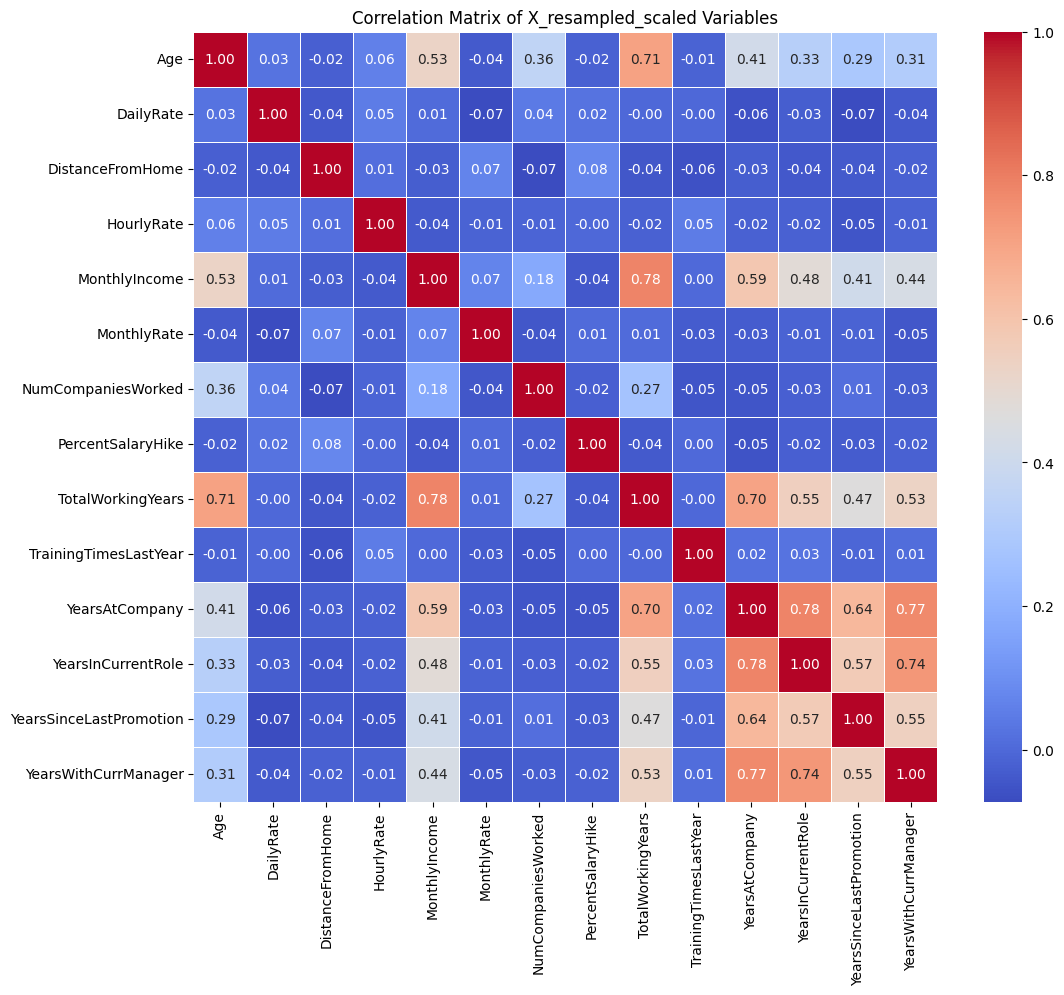

In [23]:
correlation_matrix = X_resampled_normalized.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of X_resampled_scaled Variables')
plt.show()

In [24]:
X_resampled_normalized = X_resampled_normalized.drop(['YearsWithCurrManager', 'YearsAtCompany', 'TotalWorkingYears','YearsSinceLastPromotion'], axis=1)

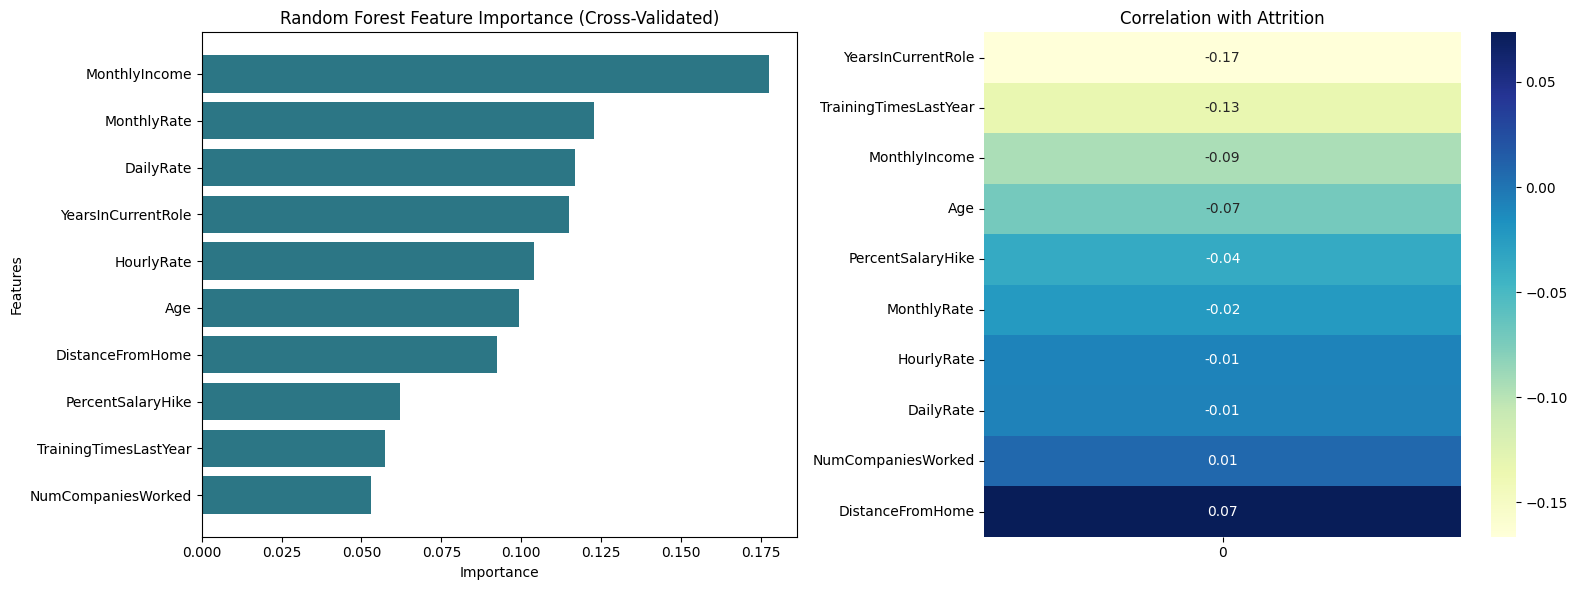

In [25]:
from sklearn.ensemble import RandomForestClassifier

# Function to plot numerical variable feature importance and correlation
def plot_numerical_features(X, y, n_folds=5):
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

    all_feature_importances = []
    
    # Plotting variables
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Feature Importance using Random Forest
    for train_index, _ in skf.split(X, y):
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]

        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        all_feature_importances.append(model.feature_importances_)

    avg_feature_importances = np.mean(all_feature_importances, axis=0)
    sorted_indices = np.argsort(avg_feature_importances)
    sorted_importances = avg_feature_importances[sorted_indices]
    sorted_feature_names = X.columns[sorted_indices]

    # Bar plot for feature importance
    axes[0].barh(range(len(sorted_importances)), sorted_importances, color='#2c7685', align='center')
    axes[0].set_yticks(range(len(sorted_importances)))
    axes[0].set_yticklabels(sorted_feature_names)
    axes[0].set_title("Random Forest Feature Importance (Cross-Validated)")
    axes[0].set_xlabel("Importance")
    axes[0].set_ylabel("Features")

    # Correlation Heatmap
    corr_matrix = X.corrwith(y).sort_values(ascending=True)  # Sort in ascending order
    sns.heatmap(corr_matrix.to_frame(), annot=True, cmap='YlGnBu', fmt=".2f", ax=axes[1])  # Change the colormap to 'YlGnBu'
    axes[1].set_title("Correlation with Attrition")

    plt.tight_layout()
    # plt.savefig('numerical_feature_importance_and_correlation_plot.png', transparent=True, dpi=300)
    plt.show()

# Run the modified function for numerical variables
plot_numerical_features(X_resampled_normalized, y_resampled, n_folds=5)

In [26]:
numerical_variables_to_keep = [
    'MonthlyIncome',
    'DailyRate',
    'MonthlyRate',
    'YearsInCurrentRole',
    'HourlyRate',
    'Age',
    'DistanceFromHome']

## 2.3. Wrap up and final transformations

In [27]:
X_num = X_resampled_normalized[numerical_variables_to_keep]
X_cat = X_resampled_categorical[categorical_variables_to_keep]

In [28]:
X_cat

,StockOptionLevel,JobLevel,JobSatisfaction,EnvironmentSatisfaction,OverTime,JobInvolvement,BusinessTravel
46,0,2,4,3,0,3,2
320,1,3,4,4,0,3,2
539,3,1,3,3,0,3,2
10,2,2,2,1,0,2,2
42,1,2,1,2,0,3,2
...,...,...,...,...,...,...,...
1804,0,1,1,3,0,3,2
1805,2,2,2,2,0,2,1
1806,0,1,1,3,0,2,2
1807,2,1,3,2,1,2,1


In [29]:
# Resetting the index of X_cat for concatenation

X_cat.reset_index(drop=True, inplace=True)

X_final = pd.concat([X_num, X_cat], axis=1)

X_final = pd.get_dummies(X_final, columns=['BusinessTravel'], prefix='BusinessTravel', dtype=int)
X_final = X_final.drop(['BusinessTravel_0'], axis = 1)
X_final = X_final.drop(['BusinessTravel_2'], axis = 1)


In [30]:
X_final

,MonthlyIncome,DailyRate,MonthlyRate,YearsInCurrentRole,HourlyRate,Age,DistanceFromHome,StockOptionLevel,JobLevel,JobSatisfaction,EnvironmentSatisfaction,OverTime,JobInvolvement,BusinessTravel_1
0,0.193523,0.337159,0.282313,0.166667,0.228571,0.190476,0.321429,0,2,4,3,0,3,0
1,0.398578,0.433286,0.718530,0.444444,0.742857,0.666667,0.035714,1,3,4,4,0,3,0
2,0.052238,0.783357,0.419795,0.166667,0.971429,0.523810,0.035714,3,1,3,3,0,3,0
3,0.296735,0.794835,0.063963,0.000000,0.685714,0.261905,0.035714,2,2,2,1,0,2,0
4,0.309847,0.650646,0.697330,0.388889,0.014286,0.476190,0.035714,1,2,1,2,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657,0.080411,0.459110,0.093796,0.055556,0.300000,0.285714,0.178571,0,1,1,3,0,3,0
1658,0.238020,0.260402,0.153383,0.111111,0.728571,0.571429,0.785714,2,2,2,2,0,2,1
1659,0.147657,0.179340,0.802811,0.055556,0.857143,0.476190,0.678571,0,1,1,3,0,2,0
1660,0.092996,0.195839,0.848665,0.222222,0.314286,0.214286,0.214286,2,1,3,2,1,2,1


# 3. Model Training

## 3.1. Cross Validation Training

- Creation of a list of models for training
    - Logistic Regression, Random Forest, XGBoost and Support Vector Machines were the models used
- Train the models on cross-validation and plot the accuracy and recall results

In [31]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
#%pip install xgboost
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [32]:
logistic_regression_model = LogisticRegression(random_state=42)
random_forest_model = RandomForestClassifier(random_state=42)
xgboost_model = XGBClassifier(random_state=42)
svm_model = SVC(probability=True,random_state=42)

In [33]:
# Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model_names = []
accuracy_scores = []
recall_scores = []

for model_name, model in [
    ("Logistic Regression", logistic_regression_model),
    ("Random Forest", random_forest_model),
    ("XGBoost", xgboost_model),
    ("SVM", svm_model)
]:
    
    accuracy = cross_val_score(model, X_final, y_resampled, cv=cv, scoring='accuracy')
    
    recall = cross_val_score(model, X_final, y_resampled, cv=cv, scoring='recall')
    
    model_names.append(model_name)
    accuracy_scores.append(np.mean(accuracy))
    recall_scores.append(np.mean(recall))

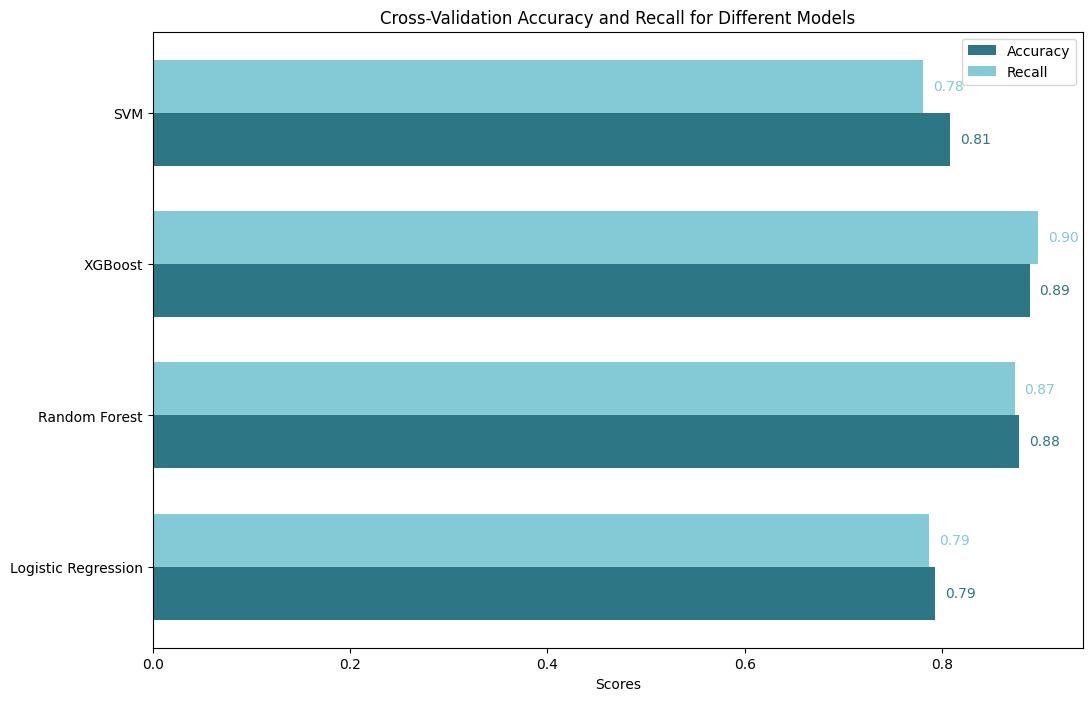

In [34]:
# Plotting
bar_width = 0.35
fig, ax = plt.subplots(figsize=(12, 8))

bar1 = ax.barh(np.arange(len(model_names)), accuracy_scores, bar_width, label='Accuracy', color='#2c7685')
bar2 = ax.barh(np.arange(len(model_names)) + bar_width, recall_scores, bar_width, label='Recall', color='#84c9d6')

ax.set_yticks(np.arange(len(model_names)) + bar_width / 2)
ax.set_yticklabels(model_names)
ax.set_xlabel('Scores')
ax.set_title('Cross-Validation Accuracy and Recall for Different Models')

# Text labels
for i, v in enumerate(accuracy_scores):
    ax.text(v + 0.01, i, f'{v:.2f}', color='#2c7685', va='center')

for i, v in enumerate(recall_scores):
    ax.text(v + 0.01, i + bar_width, f'{v:.2f}', color='#84c9d6', va='center')

ax.legend()

plt.show()

## 3.2. Performance Assesment

- Definition of a transform data function to replicate changes in data in the test set defined earlier
- Application of tranformation function to test data
- Model training in all training dataset
- Computation of predictions on test set
- Evaluation of different models through Confusion Matrix, Classification Report and ROC curve

In [35]:
def transform_test_data(input_data):
    # Drop irrelevant features
    irrelevant_features = ['EmployeeCount', 'EmployeeNumber', 'StandardHours']
    input_data = input_data.drop(irrelevant_features, axis=1)

    # Label encoding for categorical features
    def process_categorical_data(data, text_categorical_features, le, l1, l2, tf1):
        for col in data.columns:
            if data[col].dtype == 'O':
                text_categorical_features.append(col)
                data[col] = le.fit_transform(data[col])
                l1.append(list(data[col].unique()))
                l2.append(list(le.inverse_transform(data[col].unique())))
        for i in range(len(text_categorical_features)):
            tf1[text_categorical_features[i]] = {}
            for j, k in zip(l1[i], l2[i]):
                tf1[text_categorical_features[i]][j] = k

    le = LabelEncoder()
    text_categorical_features = []
    l1 = []
    l2 = []
    tf1 = {}
    process_categorical_data(input_data, text_categorical_features, le, l1, l2, tf1)

    # Drop constant variable
    input_data = input_data.drop(['Over18'], axis=1)

    # Scalling variables
    numerical_variables_to_keep = [
    'MonthlyIncome',
    'DailyRate',
    'MonthlyRate',
    'YearsInCurrentRole',
    'HourlyRate',
    'Age',
    'DistanceFromHome']
    
    categorical_variables_to_keep = [
    'StockOptionLevel',
    'JobLevel',
    'JobSatisfaction',
    'EnvironmentSatisfaction',
    'OverTime',
    'JobInvolvement',
    'BusinessTravel']

    X_test_numerical = input_data[numerical_variables_to_keep]
    X_test_categorical = input_data[categorical_variables_to_keep]

    minmax_scaler = MinMaxScaler()
    std_scaler = StandardScaler()
    
    X_test_scaled = pd.DataFrame(std_scaler.fit_transform(X_test_numerical), columns=X_test_numerical.columns)
    X_test_normalized = pd.DataFrame(minmax_scaler.fit_transform(X_test_scaled), columns=X_test_scaled.columns)
    
    X_test_categorical.reset_index(drop=True, inplace=True)
    X_test_normalized.reset_index(drop=True, inplace=True)
 
    X_test_final = pd.concat([X_test_normalized, X_test_categorical], axis=1)
    X_test_final = pd.get_dummies(X_test_final, columns=['BusinessTravel'], prefix='BusinessTravel')
    X_test_final = X_test_final.drop(['BusinessTravel_0'], axis=1)
    X_test_final = X_test_final.drop(['BusinessTravel_2'], axis=1)

    return X_test_final

In [36]:
X_test_transformed = transform_test_data(X_test)

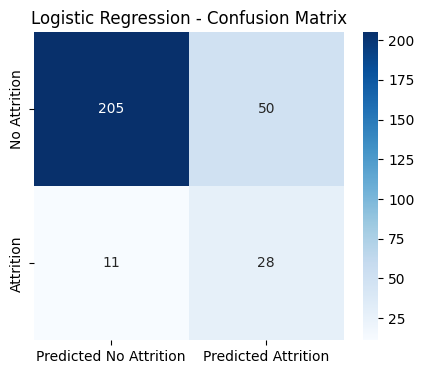

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.80      0.87       255
           1       0.36      0.72      0.48        39

    accuracy                           0.79       294
   macro avg       0.65      0.76      0.67       294
weighted avg       0.87      0.79      0.82       294

Logistic Regression - Recall Score: 0.717948717948718



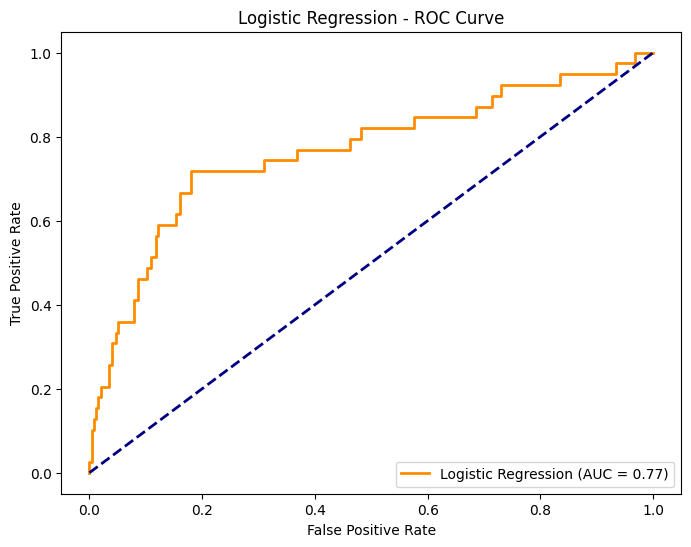

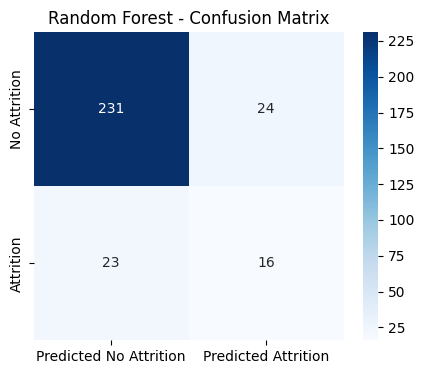

Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       255
           1       0.40      0.41      0.41        39

    accuracy                           0.84       294
   macro avg       0.65      0.66      0.66       294
weighted avg       0.84      0.84      0.84       294

Random Forest - Recall Score: 0.41025641025641024



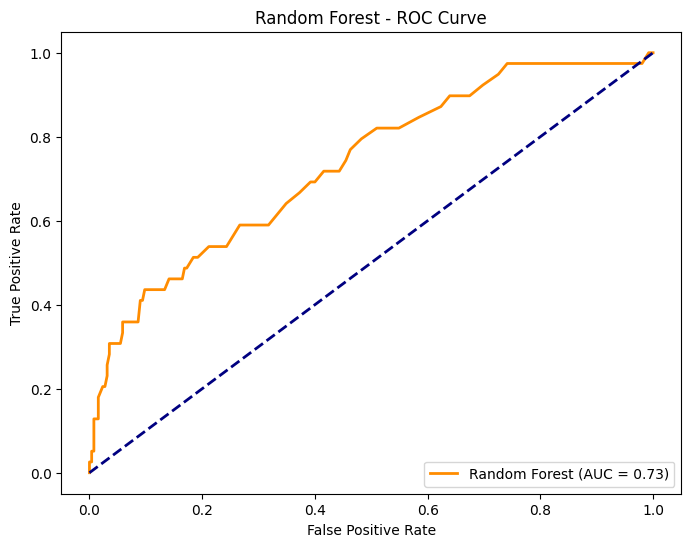

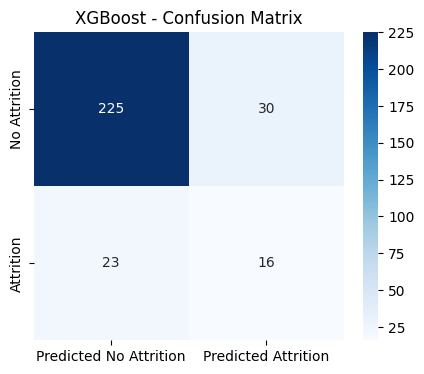

XGBoost - Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89       255
           1       0.35      0.41      0.38        39

    accuracy                           0.82       294
   macro avg       0.63      0.65      0.64       294
weighted avg       0.83      0.82      0.83       294

XGBoost - Recall Score: 0.41025641025641024



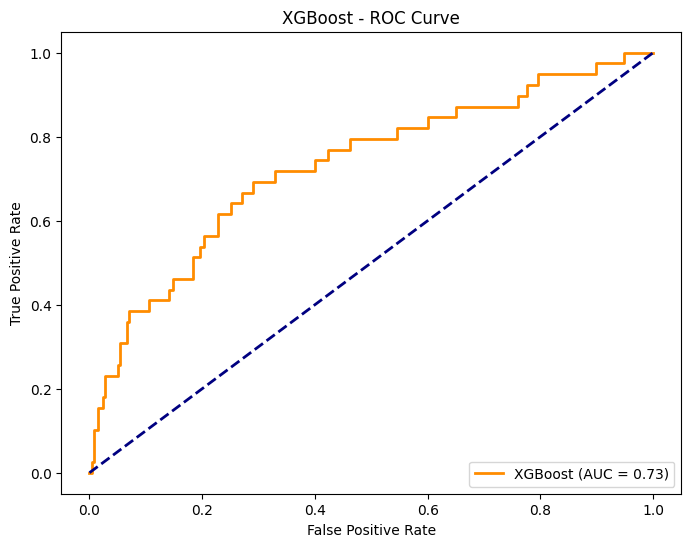

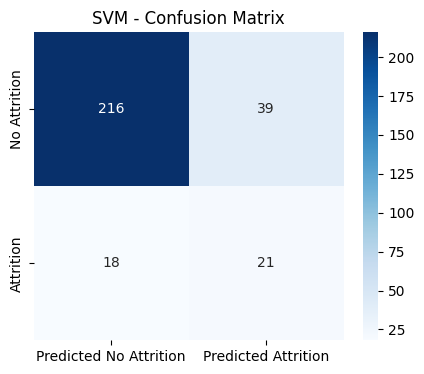

SVM - Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88       255
           1       0.35      0.54      0.42        39

    accuracy                           0.81       294
   macro avg       0.64      0.69      0.65       294
weighted avg       0.85      0.81      0.82       294

SVM - Recall Score: 0.5384615384615384



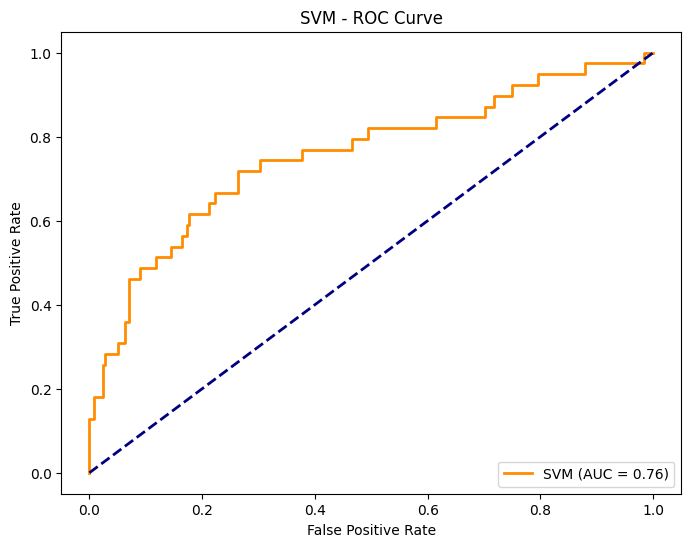

In [37]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, recall_score

# Iterate through each model
for model_name, model in [
    ("Logistic Regression", logistic_regression_model),
    ("Random Forest", random_forest_model),
    ("XGBoost", xgboost_model),
    ("SVM", svm_model)
]:
    # Train the model on the entire training dataset
    model.fit(X_final, y_resampled)

    # Make predictions on the test set
    y_pred = model.predict(X_test_transformed)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted No Attrition', 'Predicted Attrition'], yticklabels=['No Attrition', 'Attrition'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.show()

    # Classification Report
    report = classification_report(y_test, y_pred)
    print(f"{model_name} - Classification Report:\n{report}")

    # Recall Score
    recall = recall_score(y_test, y_pred)
    print(f"{model_name} - Recall Score: {recall}\n")

    # ROC Curve
    y_score = model.predict_proba(X_test_transformed)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = roc_auc_score(y_test, y_score)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# 4. Model Optimization

### Logistic Regression

In [38]:
import warnings
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
simplefilter("ignore", category=RuntimeWarning)



from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(logistic_regression_model, param_grid, cv=cv, scoring='recall')
grid_search.fit(X_final, y_resampled)

# Print the best parameters
print("Best Parameters for Logistic Regression:", grid_search.best_params_)

Best Parameters for Logistic Regression: {'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}


### Random Forest

In [39]:
# Define the parameter grid
param_grid= {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30]}

# Perform grid search with cross-validation
grid_search = GridSearchCV(random_forest_model, param_grid, cv=cv, scoring='recall')
grid_search.fit(X_final, y_resampled)

# Print the best parameters
print("Best Parameters for Random Forest:", grid_search.best_params_)

Best Parameters for Random Forest: {'max_depth': None, 'n_estimators': 300}


### XGBoost

In [40]:
# Define the parameter grid
param_grid= {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(xgboost_model, param_grid, cv=cv, scoring='recall')
grid_search.fit(X_final, y_resampled)

# Print the best parameters
print("Best Parameters for XGBoost:", grid_search.best_params_)

Best Parameters for XGBoost: {'colsample_bytree': 1.0, 'max_depth': 9, 'n_estimators': 200, 'subsample': 1.0}


### SVM

In [41]:
# Define the parameter grid
param_grid= {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm_model, param_grid, cv=cv, scoring='recall')
grid_search.fit(X_final, y_resampled)

# Print the best parameters
print("Best Parameters for SVM:", grid_search.best_params_)

Best Parameters for SVM: {'C': 0.001, 'gamma': 'scale', 'kernel': 'poly'}


# 5. Final Models and Performance Report

In [42]:
best_logistic_regression_model = LogisticRegression(C=0.1, penalty= 'l2', solver = 'saga', random_state=42)

best_random_forest_model = RandomForestClassifier(max_depth= None, n_estimators= 100, random_state=42)

best_xgboost_model = XGBClassifier(colsample_bytree= 0.8, max_depth= 7, n_estimators= 300, subsample= 0.9, random_state=42)

best_svm_model = SVC(C=0.001, gamma = 'scale', kernel = 'poly', probability=True, random_state=42)

In [43]:
# Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model_names = []
accuracy_scores = []
recall_scores = []

for model_name, model in [
    ("Logistic Regression", best_logistic_regression_model),
    ("Random Forest", best_random_forest_model),
    ("XGBoost", best_xgboost_model),
    ("SVM", best_svm_model)
]:
    
    accuracy = cross_val_score(model, X_final, y_resampled, cv=cv, scoring='accuracy')
    
    recall = cross_val_score(model, X_final, y_resampled, cv=cv, scoring='recall')
    
    model_names.append(model_name)
    accuracy_scores.append(np.mean(accuracy))
    recall_scores.append(np.mean(recall))

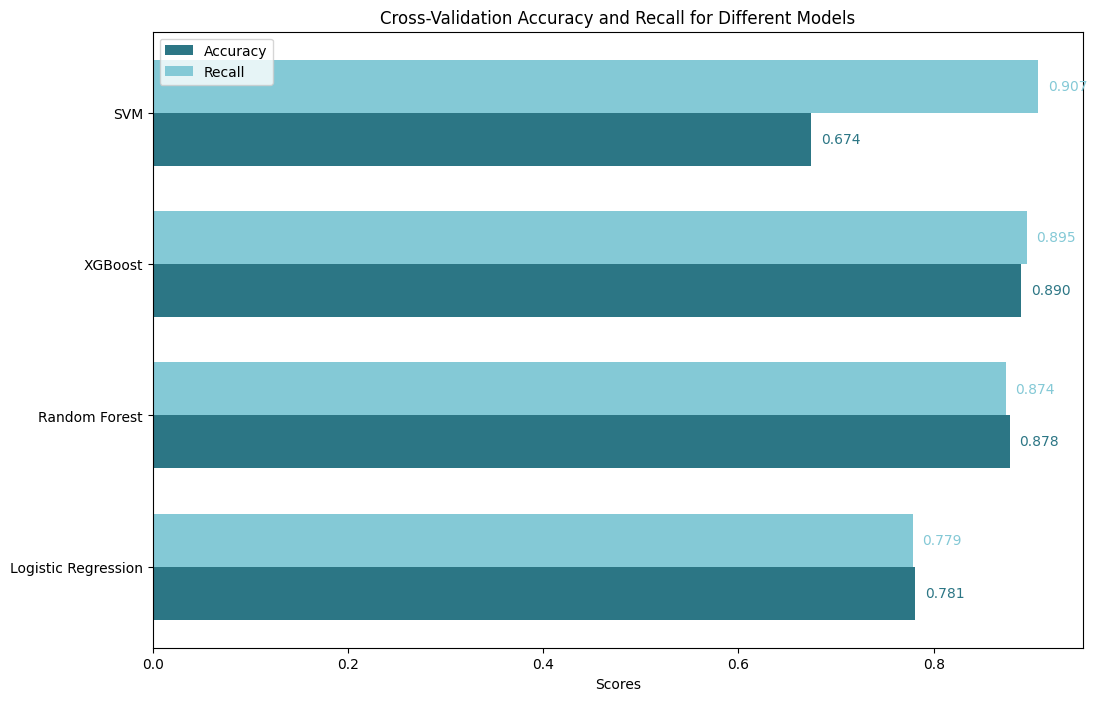

In [44]:
# Plotting
bar_width = 0.35
fig, ax = plt.subplots(figsize=(12, 8))

bar1 = ax.barh(np.arange(len(model_names)), accuracy_scores, bar_width, label='Accuracy', color='#2c7685')
bar2 = ax.barh(np.arange(len(model_names)) + bar_width, recall_scores, bar_width, label='Recall', color='#84c9d6')

ax.set_yticks(np.arange(len(model_names)) + bar_width / 2)
ax.set_yticklabels(model_names)
ax.set_xlabel('Scores')
ax.set_title('Cross-Validation Accuracy and Recall for Different Models')

# Add text labels next to the bars
for i, v in enumerate(accuracy_scores):
    ax.text(v + 0.01, i, f'{v:.3f}', color='#2c7685', va='center')

for i, v in enumerate(recall_scores):
    ax.text(v + 0.01, i + bar_width, f'{v:.3f}', color='#84c9d6', va='center')

ax.legend()
plt.savefig('cross_validation_accuracy_and_recall.png', transparent=True, dpi=300)
plt.show()

In [45]:
# Create a directory to save the figures
output_directory = "model_outputs"
os.makedirs(output_directory, exist_ok=True)

# Iterate through each model
for model_name, model in [
    ("Logistic Regression", best_logistic_regression_model),
    ("Random Forest", best_random_forest_model),
    ("XGBoost", best_xgboost_model),
    ("SVM", best_svm_model)
]:
    # Train the model on the entire training dataset
    model.fit(X_final, y_resampled)

    # Make predictions on the test set
    y_pred = model.predict(X_test_transformed)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted No Attrition', 'Predicted Attrition'], yticklabels=['No Attrition', 'Attrition'])
    plt.title(f'{model_name} - Confusion Matrix')
    # plt.savefig(os.path.join(output_directory, f'{model_name}_confusion_matrix.png'), transparent=True, dpi=300)
    plt.close()

    # Classification Report
    report = classification_report(y_test, y_pred)
    print(f"{model_name} - Classification Report:\n{report}")

    # Recall Score
    recall = recall_score(y_test, y_pred)
    print(f"{model_name} - Recall Score: {recall}\n")

    # ROC Curve
    y_score = model.predict_proba(X_test_transformed)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = roc_auc_score(y_test, y_score)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend(loc="lower right")
    # plt.savefig(os.path.join(output_directory, f'{model_name}_roc_curve.png'),transparent=True, dpi=300)
    plt.close()

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.81      0.87       255
           1       0.36      0.69      0.47        39

    accuracy                           0.80       294
   macro avg       0.65      0.75      0.67       294
weighted avg       0.87      0.80      0.82       294

Logistic Regression - Recall Score: 0.6923076923076923

Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       255
           1       0.40      0.41      0.41        39

    accuracy                           0.84       294
   macro avg       0.65      0.66      0.66       294
weighted avg       0.84      0.84      0.84       294

Random Forest - Recall Score: 0.41025641025641024

XGBoost - Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       255
           1 

In [46]:
# Assign weights to each model
weights = {
    "Logistic Regression": 3.0,
    "Random Forest": 1.0,
    "XGBoost": 2.0,
    "SVM": 3.0
}

all_predictions = []

for model_name, model in [
    ("Logistic Regression", best_logistic_regression_model),
    ("Random Forest", best_random_forest_model),
    ("XGBoost", best_xgboost_model),
    ("SVM", best_svm_model)
]:
    # Train the model on the entire training dataset
    model.fit(X_final, y_resampled)

    # Make predictions on the test set
    y_pred = model.predict(X_test_transformed)

    # Multiply predictions by the corresponding weight
    weighted_predictions = y_pred * weights[model_name]

    # Append weighted predictions to the array
    all_predictions.append(weighted_predictions)

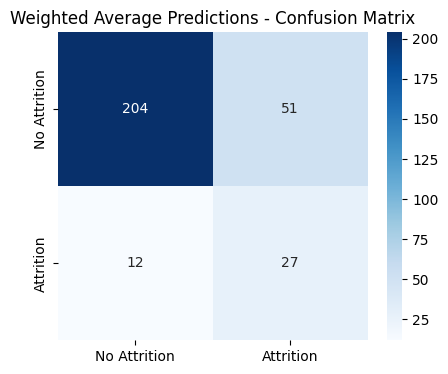

Weighted Average Predictions - Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.80      0.87       255
           1       0.35      0.69      0.46        39

    accuracy                           0.79       294
   macro avg       0.65      0.75      0.66       294
weighted avg       0.87      0.79      0.81       294

Weighted Average Predictions - Recall Score: 0.6923076923076923



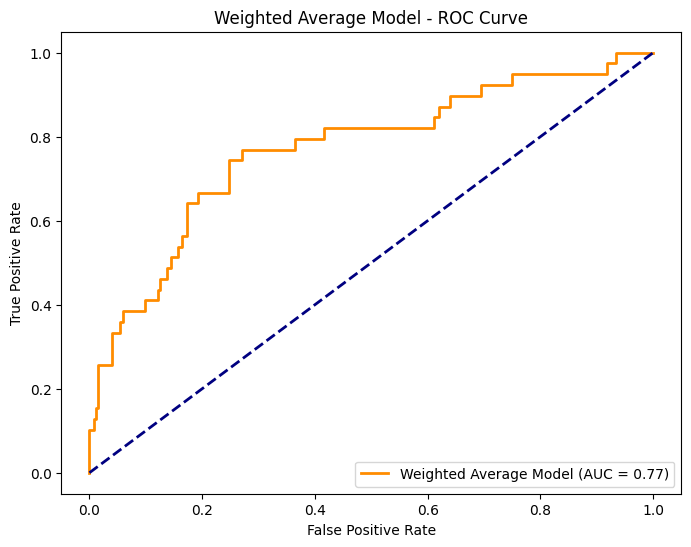

In [47]:
# Calculate the weighted average predictions
weighted_average_predictions = np.sum(all_predictions, axis=0) / sum(weights.values())
rounded_weighted_average_predictions = np.round(weighted_average_predictions)

# Confusion Matrix for Weighted Average Predictions
cm = confusion_matrix(y_test, rounded_weighted_average_predictions)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['No Attrition', 'Attrition'], yticklabels=['No Attrition', 'Attrition'])
plt.title('Weighted Average Predictions - Confusion Matrix')
plt.show()

# Classification Report for Weighted Average Predictions
report = classification_report(y_test, rounded_weighted_average_predictions)
print(f"Weighted Average Predictions - Classification Report:\n{report}")

# Recall Score for Weighted Average Predictions
recall = recall_score(y_test, rounded_weighted_average_predictions)
print(f"Weighted Average Predictions - Recall Score: {recall}\n")

# ROC Curve for Weighted Average Predictions
y_scores = np.mean([model.predict_proba(X_test_transformed)[:, 1] * weights[model_name] for model_name, model in [("Logistic Regression", best_logistic_regression_model), ("Random Forest", best_random_forest_model), ("XGBoost", best_xgboost_model), ("SVM", best_svm_model)]], axis=0)
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Weighted Average Model (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Weighted Average Model - ROC Curve')
plt.legend(loc="lower right")
plt.show()